In [1]:
import pandas as pd
df=pd.read_csv('Battery_dataset 4.csv')
df.sample(10)

,battery_id,cycle,chI,chV,chT,disI,disV,disT,BCt,SOH,RUL
44,B5,45,1.532599,4.215713,27.218615,2.068729,3.536425,34.557346,1.765217,88.260838,175
23,B5,24,1.510509,4.187591,27.967208,2.171688,3.491989,31.512482,1.883637,94.181836,196
426,B6,207,1.392636,4.167586,26.509841,1.935286,3.479248,35.537674,0.961439,48.071938,3
408,B6,189,1.476219,4.205277,25.589416,2.027751,3.918817,35.283446,1.055271,52.763536,21
386,B6,167,1.464818,4.147845,28.162166,2.126008,3.681720,33.156996,1.176577,58.828863,43
138,B5,139,1.340479,4.197210,25.966632,2.117079,3.918957,33.267555,1.320031,66.001555,81
594,B7,165,1.398595,4.207210,28.832449,2.044842,3.131112,32.968271,1.178102,58.905119,85
135,B5,136,1.469399,4.143475,25.192021,1.942458,3.370573,30.894200,1.322335,66.116766,84
331,B6,112,1.282108,4.246207,26.229406,2.022046,3.110368,35.884718,1.435632,71.781596,98
553,B7,124,1.439518,4.241536,25.617123,1.958710,3.175909,33.907330,1.386146,69.307323,126


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GRU, Dropout, Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from scipy.optimize import curve_fit

# Define CNN-GRU model architecture
def create_cnn_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(10, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # Add temporal dimension for GRU
    x = GRU(60, activation='tanh')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mse')
    return model

# Double exponential function used in particle filter
def double_exp(k, a, b, c, d):
    return a * np.exp(b * k) + c * np.exp(d * k)

# Particle Filter class for parameter fusion
class ParticleFilter:
    def __init__(self, num_particles, param_init, noise_std=1e-4):
        self.N = num_particles
        self.params = np.array([param_init] * self.N, dtype=float)
        self.weights = np.ones(self.N) / self.N
        self.noise_std = noise_std

    def predict(self):
        self.params += np.random.normal(0, self.noise_std, self.params.shape)

    def update(self, k, observation):
        preds = np.array([double_exp(k, *p) for p in self.params])
        likelihoods = np.exp(-0.5 * ((observation - preds) ** 2) / (self.noise_std ** 2))
        self.weights *= likelihoods
        self.weights += 1e-300
        self.weights /= np.sum(self.weights)
        cumulative_sum = np.cumsum(self.weights)
        cumulative_sum[-1] = 1.
        indexes = np.searchsorted(cumulative_sum, np.random.rand(self.N))
        self.params = self.params[indexes]
        self.weights.fill(1.0 / self.N)

    def estimate(self, k):
        est_param = np.average(self.params, axis=0, weights=self.weights)
        estimate = double_exp(k, *est_param)
        return estimate, est_param

# Training function on large dataset
def train_model_on_dataset(df, window_size=20, epochs=80, batch_size=8, model_weights_path='cnn_gru_battery.weights.h5'):
    # Use single battery example or loop for all batteries to get bigger data
    battery_id = df['battery_id'].iloc[0]
    battery_df = df[df['battery_id'] == battery_id].reset_index(drop=True)
    full_window = battery_df['BCt'].values

    # Prepare windowed training sequences and labels
    X = np.array([full_window[i:i+window_size-1] for i in range(len(full_window)-window_size)])
    y = np.array([full_window[i+window_size-1] for i in range(len(full_window)-window_size)])
    X = X[..., np.newaxis]

    model = create_cnn_gru_model((window_size-1, 1))
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    model.save_weights(model_weights_path)
    print(f"Model trained and saved at {model_weights_path}")
    return model


# Prediction function using pretrained model and user input
def predict_soh_rul(user_inputs, window_size=20, model_weights_path='/content/cnn_gru_battery.weights.h5'):
    window_data = np.array(user_inputs['window_data'])

    # Prepare input windows
    X = np.array([window_data[i:i+window_size-1] for i in range(len(window_data)-window_size+1)])
    y = np.array([window_data[i+window_size-1] for i in range(len(window_data)-window_size+1)])
    X = X[..., np.newaxis]

    # Load pretrained model weights
    model = create_cnn_gru_model((window_size-1,1))
    model.load_weights(model_weights_path)

    try:
        popt, _ = curve_fit(double_exp, np.arange(window_size-1), window_data[:-1], maxfev=4000,
                            bounds=([0, -np.inf, 0, -np.inf], [np.inf, 0, np.inf, 0]))
    except:
        popt = [window_data[-1], -0.01, window_data[-1]/2, -0.01]

    pf = ParticleFilter(300, popt, 0.0005)
    current_series = window_data.copy()
    predictions = []

    failure_threshold = 0.7 * user_inputs['capacity']

    for k in range(window_size-1, window_size+200):
        xin = current_series[-(window_size-1):].reshape(1, window_size-1, 1)
        pred_cap = float(model.predict(xin, verbose=0)[0,0])
        pf.predict()
        pf.update(k, pred_cap)
        pf_cap, _ = pf.estimate(k)
        current_series = np.append(current_series[1:], pf_cap)
        predictions.append(pf_cap)

        # Optional iterative retraining can be disabled for speed
        # X_new = np.array([current_series[i:i+window_size-1] for i in range(len(current_series)-(window_size-1))])
        # y_new = np.array([current_series[i+window_size-1] for i in range(len(current_series)-(window_size-1))])
        # X_new = X_new[..., np.newaxis]
        # model.fit(X_new, y_new, epochs=5, batch_size=8, verbose=0)

        if pf_cap <= failure_threshold:
            break

    rul_cycles = len(predictions)
    soh_estimated = pf_cap / user_inputs['capacity'] * 100

    return round(soh_estimated, 2), rul_cycles



Matplotlib is building the font cache; this may take a moment.


Training and evaluating for battery: B5
Battery B5 training sequences: 136
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8148
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0823
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0581
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0445
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0450
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0383
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0318
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0386
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0330
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0358
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training and evaluating for battery: B6
Battery B6 training sequences: 128
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7237
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0709
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0464
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0633
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0420
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0580
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0615
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0491
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0384
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0255
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training and evaluating for battery: B7
Battery B7 training sequences: 160
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2392
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0813
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0588
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0544
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0369
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0307
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0259
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training and evaluating for battery: B18
Battery B18 training sequences: 0
Skipping plotting for B18 due to insufficient training data.
Training and evaluating for battery: CS35
Battery CS35 training sequences: 0
Skipping plotting for CS35 due to insufficient training data.
Training and evaluating for battery: CS36
Battery CS36 training sequences: 0
Skipping plotting for CS36 due to insufficient training data.
Training and evaluating for battery: CS37
Battery CS37 training sequences: 0
Skipping plotting for CS37 due to insufficient training data.
Training and evaluating for battery: CS38
Battery CS38 training sequences: 0
Skipping plotting for CS38 due to insufficient training data.
Training and evaluating for battery: LB10
Battery LB10 training sequences: 0
Skipping plotting for LB10 due to insufficient training data.
Training and evaluating for battery: LB12
Battery LB12 training sequences: 0
Skipping plotting for LB12 due to insufficient training data.


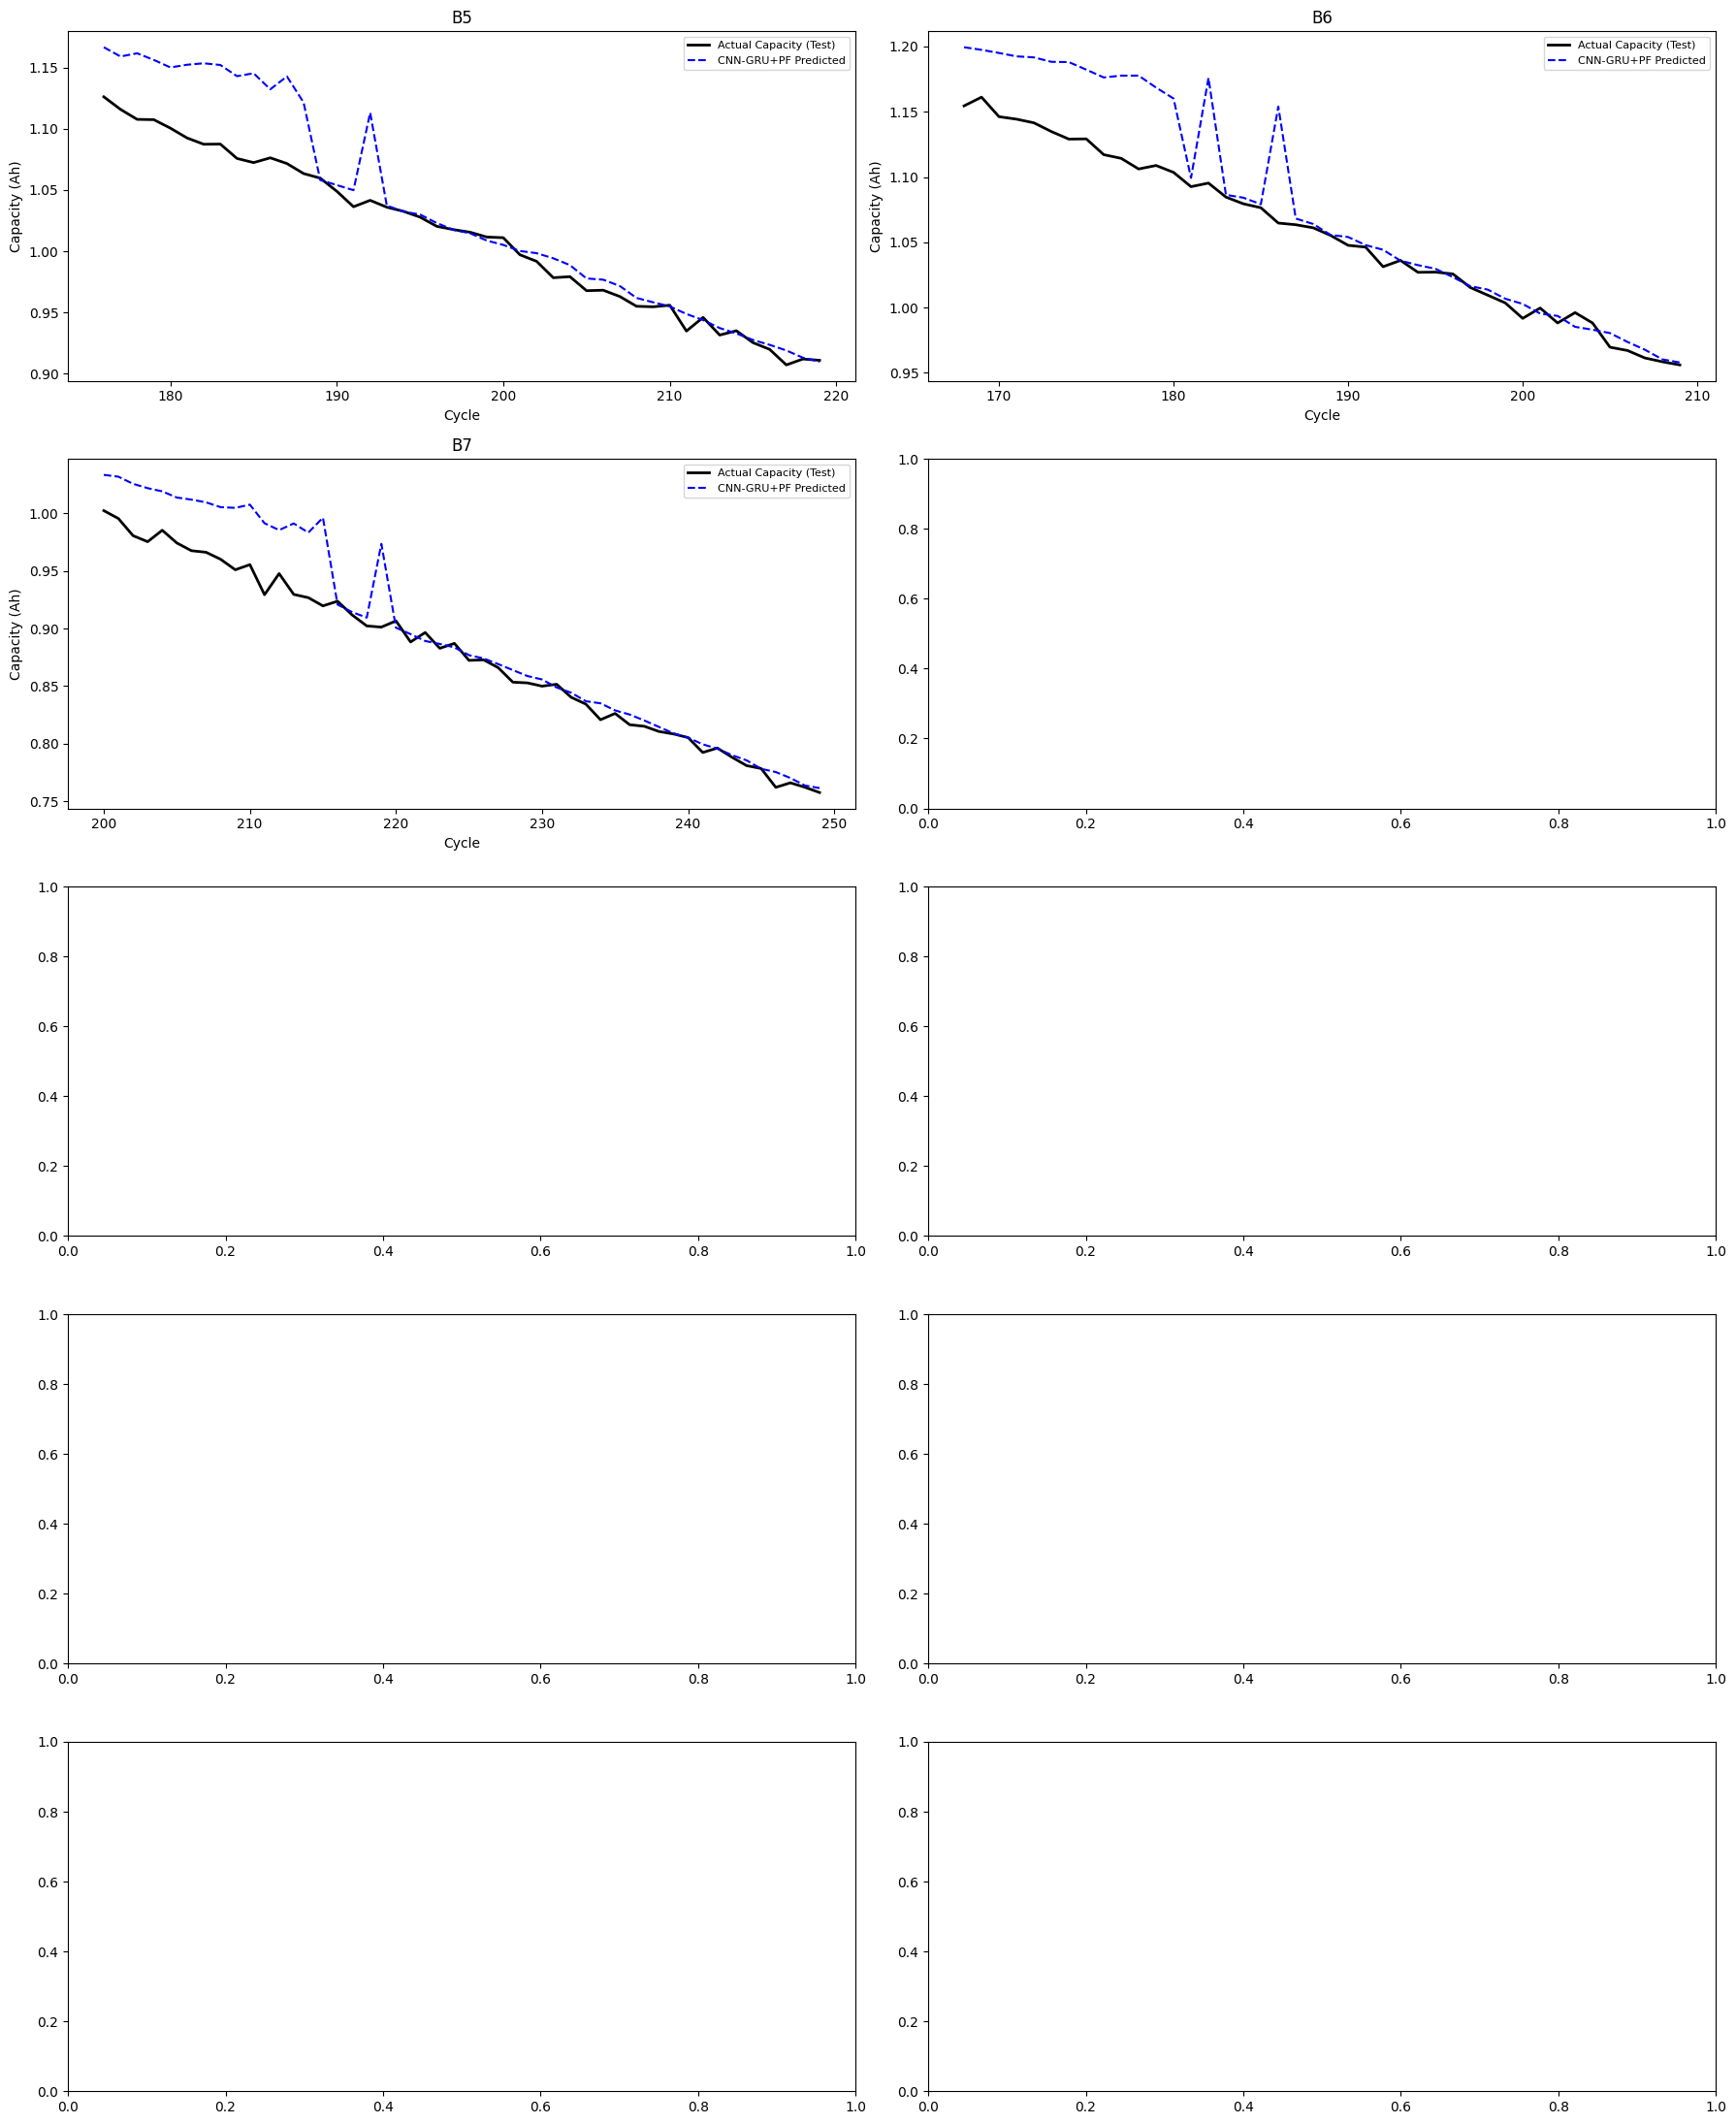


Test set Mean Squared Errors:
B5: 0.013890875411470277
B6: 0.014159007524339774
B7: 0.01088437602052515


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train_and_evaluate_battery(df, battery_id, window_size=40, epochs=100, batch_size=8, test_ratio=0.2):
    battery_df = df[df['battery_id'] == battery_id].reset_index(drop=True)
    full_seq = battery_df['BCt'].values

    split_idx = int(len(full_seq) * (1 - test_ratio))
    train_seq = full_seq[:split_idx]
    test_seq = full_seq[split_idx - window_size:]  # overlap for windowing

    # Prepare training data windows
    X_train = np.array([train_seq[i:i+window_size-1] for i in range(len(train_seq) - window_size)])
    y_train = np.array([train_seq[i+window_size-1] for i in range(len(train_seq) - window_size)])
    X_train = X_train[..., np.newaxis]

    # Defensive check on training data size
    print(f"Battery {battery_id} training sequences: {len(X_train)}")
    if len(X_train) < max(1, batch_size):
        print(f"WARNING: Skipping training for {battery_id} due to insufficient training sequences")
        return None, None

    # Prepare test data windows
    X_test = np.array([test_seq[i:i+window_size-1] for i in range(len(test_seq) - window_size)])
    y_test = np.array([test_seq[i+window_size-1] for i in range(len(test_seq) - window_size)])
    X_test = X_test[..., np.newaxis]

    # Create and train model
    model = create_cnn_gru_model((window_size-1, 1))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    model_weights_path = f'{battery_id}_cnn_gru_battery.weights.h5'
    model.save_weights(model_weights_path)
    print(f"Model trained and saved for {battery_id} at {model_weights_path}")

    # Evaluate on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Test MSE for {battery_id}: {mse}")

    # Generate predicted capacity curve on test set using CNN-GRU + PF fusion
    ruled_pred = []
    pred_cycles = np.arange(split_idx, len(full_seq))

    current_window = full_seq[split_idx-window_size:split_idx].tolist()
    initial_capacity = full_seq[0]

    for k in range(split_idx, len(full_seq)):
        user_inputs = {
            'window_data': current_window,
            'capacity': initial_capacity
        }
        soh, _ = predict_soh_rul(user_inputs, window_size=window_size, model_weights_path=model_weights_path)
        ruled_pred.append(soh / 100 * initial_capacity)
        current_window.append(full_seq[k])
        current_window = current_window[-window_size:]

    return ruled_pred, pred_cycles, y_test, mse


def batch_train_eval_plot(df, battery_ids, window_size=40, epochs=100, batch_size=8, test_ratio=0.2):
    fig, axs = plt.subplots(5, 2, figsize=(18, 22))
    axs = axs.flatten()

    test_mse_list = []

    for i, battery_id in enumerate(battery_ids):
        print(f"Training and evaluating for battery: {battery_id}")
        results = train_and_evaluate_battery(df, battery_id, window_size, epochs, batch_size, test_ratio)
        if results == (None, None):
            print(f"Skipping plotting for {battery_id} due to insufficient training data.")
            continue
        ruled_pred, pred_cycles, y_test, mse = results
        test_mse_list.append((battery_id, mse))

        ax = axs[i]
        ax.plot(pred_cycles, y_test, label="Actual Capacity (Test)", color='black', linewidth=2)
        ax.plot(pred_cycles, ruled_pred, label="CNN-GRU+PF Predicted", color='blue', linestyle='--')
        ax.set_title(battery_id)
        ax.set_xlabel("Cycle")
        ax.set_ylabel("Capacity (Ah)")
        ax.legend(loc="best", fontsize=8)

    plt.tight_layout()
    plt.show()

    print("\nTest set Mean Squared Errors:")
    for battery, mse in test_mse_list:
        print(f"{battery}: {mse}")


# Example usage:
input_data = pd.read_csv('/content/Battery_dataset 2.csv')
battery_ids = ['B5', 'B6', 'B7', 'B18', 'CS35', 'CS36', 'CS37', 'CS38', 'LB10', 'LB12']
batch_train_eval_plot(input_data, battery_ids, window_size=40, epochs=100, batch_size=8, test_ratio=0.2)


In [12]:
# --- Usage Example ---

# Load your dataset CSV file here
df = pd.read_csv('/content/Battery_dataset 2.csv')

# Step 1: Train model on dataset (run once)
model = train_model_on_dataset(df, window_size=20, epochs=100, batch_size=8)

# Step 2: Prepare user input for prediction (could come from battery specs or user measurement)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6585
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0773
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0616
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0568
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0344
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0332
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0319
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0293
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220
Epoc

In [13]:
user_inputs = {
    'cycle': 150,
    'voltage': 3.7,
    'current': 1.0,
    'temperature': 30.0,
    'capacity': 2800,
    'window_data': [
        2950, 2920, 2890, 2860, 2830, 2800, 2770, 2740, 2710, 2680,
        2650, 2620, 2590, 2560, 2530, 2500, 2470, 2440, 2410, 2380
    ]
}

# Step 3: Predict using pretrained model
soh, rul = predict_soh_rul(user_inputs, window_size=20, model_weights_path='/content/cnn_gru_battery.weights.h5')
print(f"Estimated State of Health (SOH): {soh}%")
print(f"Estimated Remaining Useful Life (RUL): {rul} cycles")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Estimated State of Health (SOH): 69.47%
Estimated Remaining Useful Life (RUL): 21 cycles
